# Holland model
## reading GDACS data

### Import Python lib ...

In [52]:
#%matplotlib notebook
import pandas
import matplotlib.pyplot as plt
import numpy as np
from xmldic import bxml

from scipy.interpolate import griddata
from mpl_toolkits.basemap import Basemap
from getmedf import *

from datetime import datetime,timedelta

## PARAMETERS

In [53]:
nm2m=1852. # 1 nautical mile to meters
kt2ms=nm2m/3600.  # knots to m/s
omega=2*np.pi/(3600.*24.) # angular speed omega=2pi*f(=frequency of earth : 1 cycle per day) 2pi* 1 / day in seconds
rhoa=1.15 #air density  Kg/m^3
radius=6378388 #137. # earth's radius according to WGS 84
deg2m=np.pi*radius/180.  # ds on cicle equals ds=r*dth - dth=pi/180
pn=101000.  # Atmospheric pressure [N/m^2] (101KPa - enviromental pressure)

tetaNE=45. #mean angle [degrees] of North Eastern quadrant
tetaNW=135. #        "              North Western
tetaSW=225. #        "              South West
tetaSE=315. #        "              South East

maxR=500.e3  # maximum radius of TC [m] (500Km)

## FUNCTIONS

##### f coriolis

In [54]:
def fcor(lat,omega):
    return 2*omega*np.sin(np.deg2rad(lat))

# def lat (function of grid)

##### Calculate x

In [55]:
def calcx1(r,rmax,maxR,k):
    x=[]
    for index in range(len(r)):   
        if r[index]<rmax:
            xi=0.5    
        elif r[index]==rmax:
            xi=0.5    
        elif r[index]>rmax:
            xi=0.5+(r[index]-rmax)/(maxR-rmax)*k         
        x=np.append(x,xi)           
    return x

In [56]:
def calcx2(r,rmax,maxR,k):
  
    m=np.shape(r)
    mtot=m[1] # da sistemare
    
    x=np.zeros(m)
    for i in range(0, mtot, 1):   
        for j in range(0, mtot, 1):
            if r[i][j]<rmax:
                xi=0.5    
            elif r[i][j]==rmax:
                xi=0.5    
            elif r[i][j]>rmax:
                xi=0.5+(r[i][j]-rmax)/(maxR-rmax)*k         
            x[i][j]=xi           
    return x

##### Inflow angle correction

In [57]:
def calcbeta(r,rmax):
    m=np.shape(r)
    mtot=m[1] # da sistemare
    
    beta=np.zeros(m)
    for i in range(0, mtot, 1):   
        for j in range(0, mtot, 1):   
            if r[i][j]>(rmax*1.2):
                betai=25    
            elif r[i][j]>rmax:
                betai=85*(r[i][j]/rmax)-65    
            else: 
                betai=10*r[i][j]/rmax
            beta[i][j]=betai    
    return beta

##### Pressure

In [58]:
def pres(r, dp, pn, rmax, b):
    pc=pn-dp
    return pc+dp*np.exp(-(rmax/r)**b)

r = radius
pch = Central Pressure (Pc)
dph = Pressure Drop=(Pn-Pc)
rmaxh = Radius of max winds (Rmax)
bh = Holland's parameter (B)

##### Velocity

In [59]:
# Velocity without Coriolis
def vel(r,b,rhoa,rmax,maxR,k,dp,x):
    return (b/rhoa*(rmax/r)**b*dp*np.exp(-(rmax/r)**b))**x

In [60]:
# Velocity with Coriolis
def velcor(r,b,rhoa,rmax,maxR,k,dp,x,f):
    return (b/rhoa*(rmax/r)**b*dp*np.exp(-(rmax/r)**b)+(r*(np.absolute(f))/2)**(1/x))**x-r*(np.absolute(f))/2

In [61]:
def vel2(r, theta, vtx,vty, dp, pn, rmax, b, k, x):
     
    vr=(b/rhoa*(rmax/r)**b*dp*np.exp(-(rmax/r)**b))**x #use vel
     
    vx=-vr*np.sin(theta)
    vxs=vx+vtx*(1.-np.exp(-(rmax/r)**b))
    
    vy=vr*np.cos(theta)
    vys=vy+vty*(1.-np.exp(-(rmax/r)**b))

    return vx,vy,vxs,vys

In [62]:
def vel2cor(r, theta, vtx,vty, dp, pn, rmax, b, k, x,f):
     
    vr=(b/rhoa*(rmax/r)**b*dp*np.exp(-(rmax/r)**b)+(r*(np.absolute(f))/2)**(1/x))**x-r*(np.absolute(f))/2
     
    vx=-vr*np.sin(theta)
    vxs=vx+vtx*(1.-np.exp(-(rmax/r)**b))
    
    vy=vr*np.cos(theta)
    vys=vy+vty*(1.-np.exp(-(rmax/r)**b))

    return vx,vy,vxs,vys

## TC Input Data (GDACS)

In [63]:
hurName='MALAKAS'
GDACShome='/mnt/web/cycloneSurgeVM/'
GDACSpath=GDACShome+'1000305_JTWC'
bul=16
GDACSdir=GDACSpath+'/{}'.format(bul)
outfile=GDACSdir+'/outData.txt'

print ('Name:'+hurName)
print('Input GDACS Dir: '+GDACSpath)
print ('Bulletin:'+(str(bul)))
print('InputDir: '+ GDACSpath)
print('Info in outData.txt file in: '+ outfile+'\n')

datH=pandas.read_csv(outfile,header=0,delimiter='\t',usecols=np.arange(0,14))
datH

Name:MALAKAS
Input GDACS Dir: /mnt/web/cycloneSurgeVM/1000305_JTWC
Bulletin:16
InputDir: /mnt/web/cycloneSurgeVM/1000305_JTWC
Info in outData.txt file in: /mnt/web/cycloneSurgeVM/1000305_JTWC/16/outData.txt



,time,xhc,yhc,b,k,rmax,deltap,vmax,vmax0,vtr,vtrx,vtry,bias,rmse
0,0.0,126.8,18.4,0.943078,0.060153,16096.0,4391.10,46.296,36.3969,6.56504,-4.645860,4.63850,0.778419E-01,1.40064
1,12.0,124.9,20.2,0.863559,0.061822,10265.0,6186.99,51.440,41.3418,6.24065,-3.869500,4.89619,-0.759028E-01,1.35125
2,24.0,123.6,22.2,0.975799,0.093773,10325.5,6975.02,56.584,46.6613,5.67935,-2.385910,5.15387,0.467049,2.12331
3,36.0,122.9,24.2,1.026390,0.106652,10366.3,7613.85,59.156,49.9990,4.73281,-0.940187,4.63849,0.415282,2.28051
4,48.0,122.8,25.8,0.946652,0.076973,10550.8,7091.16,54.012,46.3402,3.68345,0.533013,3.64468,-0.278134E-01,1.85791
5,72.0,124.6,28.1,0.887670,0.080130,21457.3,4081.23,41.152,34.0428,4.54037,3.567840,2.80810,0.439323E-01,1.02998
6,96.0,128.9,30.4,0.887670,0.080130,21457.3,3937.04,33.436,24.2399,6.52119,5.693040,3.18044,NaN,NaN
7,120.0,134.5,33.0,0.887670,0.080130,21457.3,1886.98,23.148,14.2012,7.09500,6.221450,3.41066,NaN,NaN


In [64]:
timeH=datH['time'].values
latH=datH['yhc'].values
lonH=datH['xhc'].values
bH=datH['b'].values
kH=datH['k'].values
rmaxH=datH['rmax'].values
dpH=datH['deltap'].values
vmaxmsH=datH['vmax'].values
vmax0msH=datH['vmax0'].values
vtrxH=datH['vtrx'].values
vtryH=datH['vtry'].values
vtrH=datH['vtr'].values

##### 1 SPECIFIC TIME

In [65]:
# choose time
it=0

In [66]:
lat=latH[it]
lon=lonH[it]
b=bH[it]
vmax=vmaxmsH[it]
vmax0=vmax0msH[it]
k=kH[it]
rmax=rmaxH[it]
dp=dpH[it]
pc=pn-dp
vtx=vtrxH[it]
vty=vtryH[it]
vt=vtrH[it]

In [67]:
print 'b: ', b
print 'vmax: ', vmax
print 'vmax0: ', vmax0
print 'k: ', k
print 'rmax: ', rmax
print 'dp: ', dp
print 'pc: ', pc
print 'vt: ', vt
print 'vtx: ', vtx
print 'vty: ', vty
print 'lat TC: ', lat
print 'lon TC: ', lon


b:  0.943078
vmax:  46.296
vmax0:  36.3969
k:  0.0601533
rmax:  16096.0
dp:  4391.1
pc:  96608.9
vt:  6.56504
vtx:  -4.64586
vty:  4.6385
lat TC:  18.4
lon TC:  126.8


# Holland model


## 1) in km

##### Calculate r, grid, ...

In [68]:
r1=np.linspace(0,500000,1000)

ni,nj=1000,1000
xl=np.linspace(-maxR, maxR,ni+1)
yl=np.linspace(-maxR, maxR,nj+1)
l1,l2=np.meshgrid(xl,yl) #in km
theta=np.arctan2(l2,l1)

r2=np.sqrt(l1**2+l2**2)

##### Calculate x, x2d

In [69]:
x1=calcx1(r1,rmax,maxR,k)

In [70]:
x2=calcx2(r2,rmax,maxR,k)

##### Calculate pressure 

In [71]:
pr1=pres(r1, dp, pn, rmax, b)
pr2=pres(r2, dp, pn, rmax, b)

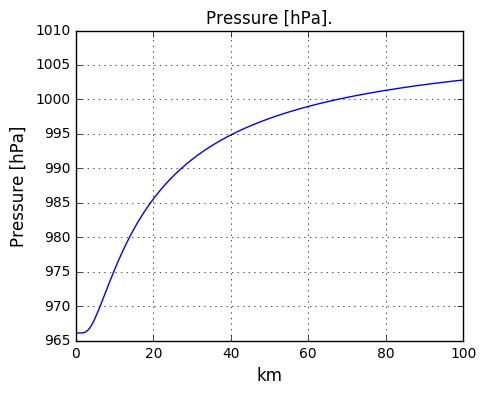

In [72]:
plt.figure(figsize=(5,4))
plt.plot(r1/1000,pr1/100)
plt.xlabel('km',fontsize=12)
plt.ylabel('Pressure [hPa]',fontsize=12)
plt.title('Pressure [hPa].')
plt.grid(True)
plt.xlim((0,100))
plt.show()

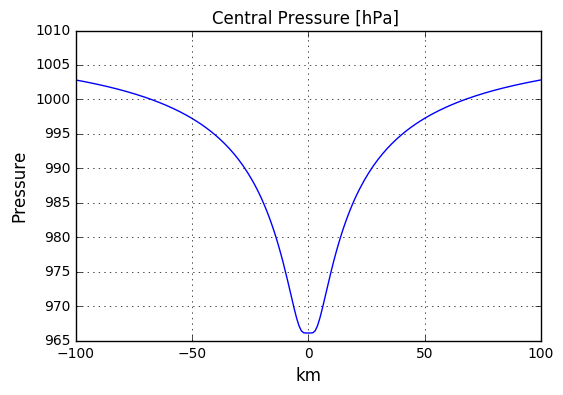

In [73]:
plt.figure(figsize=(6,4))
plt.plot(l1[0,:]/1000,pr2[500,:]/100)
plt.xlabel('km',fontsize=12)
plt.ylabel('Pressure',fontsize=12)
plt.title('Central Pressure [hPa] ')
plt.grid(True)
plt.xlim((-100,100))
plt.show()

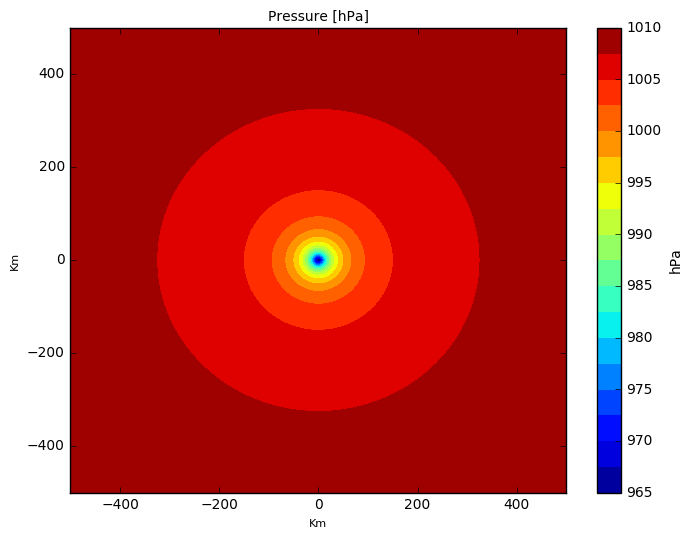

In [74]:
plt.figure(figsize=(8,6))
plt.contourf(l1/1000,l2/1000,pr2/100,20)
plt.xlabel('Km',fontsize=8)
plt.ylabel('Km',fontsize=8)
plt.title('Pressure [hPa]',fontsize=10)
plt.colorbar(label='hPa')
plt.show()

##### Calculate wind

In [75]:
vr1=vel(r1,b,rhoa,rmax,maxR,k,dp,x1)

In [76]:
vr2=vel(r2,b,rhoa,rmax,maxR,k,dp,x2)

In [77]:
f=fcor(lat, omega)
print f
# add f function of lat

4.59092914623e-05


In [78]:
vrcor=velcor(r1,b,rhoa,rmax,maxR,k,dp,x1,f)

In [79]:
ux,uy, zx,zy=vel2(r2,theta,vtx,vty, dp, pn, rmax, b, k, x2)
vtot=np.sqrt(ux**2+uy**2) # without translational velocity
vtotvt=np.sqrt(zx**2+zy**2)# with translational velocity

In [80]:
uxc,uyc, zxc,zyc=vel2cor(r2,theta,vtx,vty, dp, pn, rmax, b, k, x2,f)
vtotc=np.sqrt(uxc**2+uyc**2) # without translational velocity
vtotvtc=np.sqrt(zxc**2+zyc**2)# with translational velocity

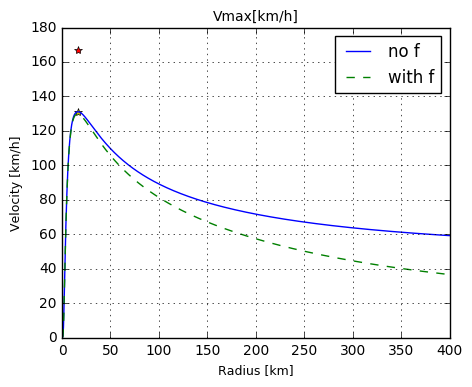

In [81]:
plt.figure(figsize=(5,4))
plt.plot(rmax/1000,vmax*3.6, '*r')
plt.plot(rmax/1000,vmax0*3.6,'*y')
plt.plot(r1/1000,(vr1*3.6),'-b',label='no f')
plt.plot(r1/1000,(vrcor*3.6),'--g',label='with f')
plt.xlabel('Radius [km]',fontsize=9)
plt.ylabel('Velocity [km/h]',fontsize=9)
plt.title('Vmax[km/h]',fontsize=10)
plt.xlim((0,400))
plt.legend(loc=0)
plt.grid(True)
plt.show()

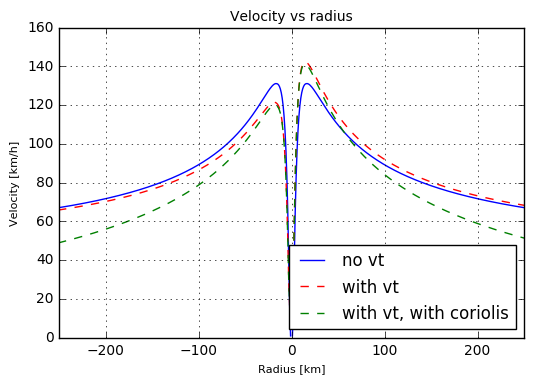

In [82]:
plt.figure(figsize=(6,4))
plt.plot(l1[0,:]/1000,vtot[ni/2,:]*3.6,'-b', label='no vt')
plt.plot(l1[0,:]/1000,vtotvt[ni/2,:]*3.6,'--r',label='with vt')
plt.plot(l1[0,:]/1000,vtotvtc[ni/2,:]*3.6,'--g',label='with vt, with coriolis')
plt.xlabel('Radius [km]',fontsize=8)
plt.ylabel('Velocity [km/h]',fontsize=8)
plt.title('Velocity vs radius',fontsize=10)
plt.xlim((-250,250))
plt.grid(True)
plt.legend(loc=0)
plt.show()

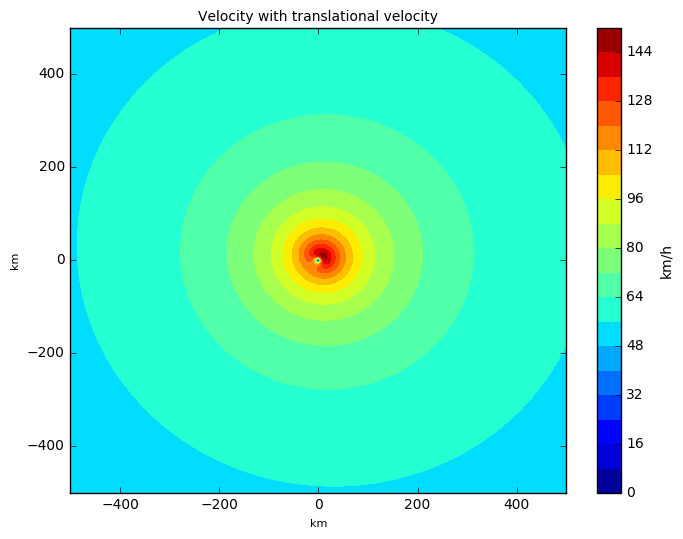

In [83]:
plt.figure(figsize=(8,6))
plt.contourf(l1/1000,l2/1000,vtotvt*3.6,20)
plt.xlabel('km',fontsize=8)
plt.ylabel('km',fontsize=8)
plt.title('Velocity with translational velocity',fontsize=10)
plt.colorbar(label='km/h')
plt.show()

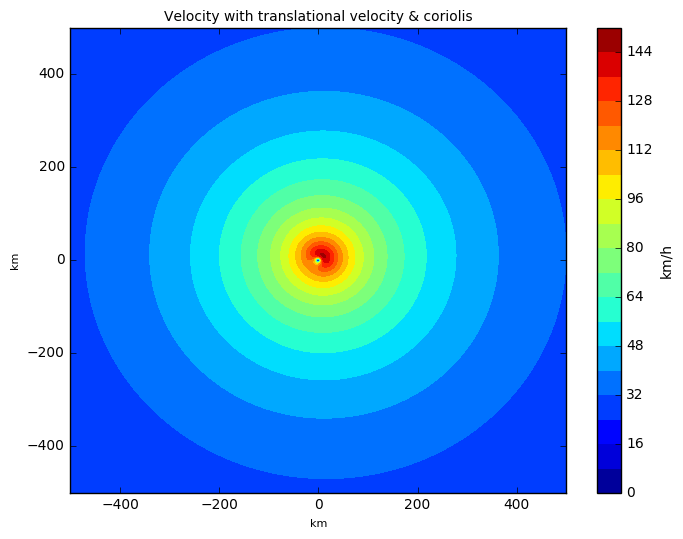

In [84]:
plt.figure(figsize=(8,6))
plt.contourf(l1/1000,l2/1000,vtotvtc*3.6,20)
plt.xlabel('km',fontsize=8)
plt.ylabel('km',fontsize=8)
plt.title('Velocity with translational velocity & coriolis',fontsize=10)
plt.colorbar(label='km/h')
plt.show()

## 2) in ° (lat, lon)

In [85]:
# deg to rad
deg2rad=np.pi/180
deg2m=deg2rad*radius

In [86]:
# Define Lat and Lon of TC's center
xhc=lon
yhc=lat
print 'TC center (lat/lon): ', yhc, '/', xhc

TC center (lat/lon):  18.4 / 126.8


In [87]:
# create grid in °
xcell0=np.linspace(xhc-10,xhc+10,1000)
ycell0=np.linspace(yhc-10,yhc+10,1000)
xcell,ycell=np.meshgrid(xcell0,ycell0)

In [88]:
#np.shape(xcell0)
#np.shape(ycell0)
#np.shape(xcell)

In [89]:
# calculate distance between TC center and point (cell)
coscellm=np.cos(np.deg2rad(yhc-ycell))
dycell=(ycell-yhc)*deg2m
dxcell=(xcell-xhc)*deg2m*coscellm
rcell=np.sqrt((dxcell)**2+(dycell)**2) # max(rcell,1000)
costeta=dxcell/rcell
sinteta=dycell/rcell


In [90]:
# calculate pressure field
prcell=pres(rcell, dp, pn, rmax, b)

In [91]:
#np.shape(prcell)
#np.shape(rcell)

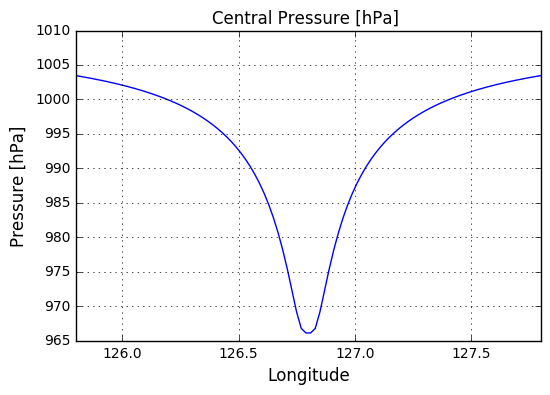

In [92]:
# Plot pressure
plt.figure(figsize=(6,4))
plt.plot(xcell[0,:],prcell[500,:]/100)
plt.xlabel('Longitude',fontsize=12)
plt.ylabel('Pressure [hPa]',fontsize=12)
plt.title('Central Pressure [hPa] ')
plt.grid(True)
plt.xlim((xhc-1,xhc+1))
plt.show()


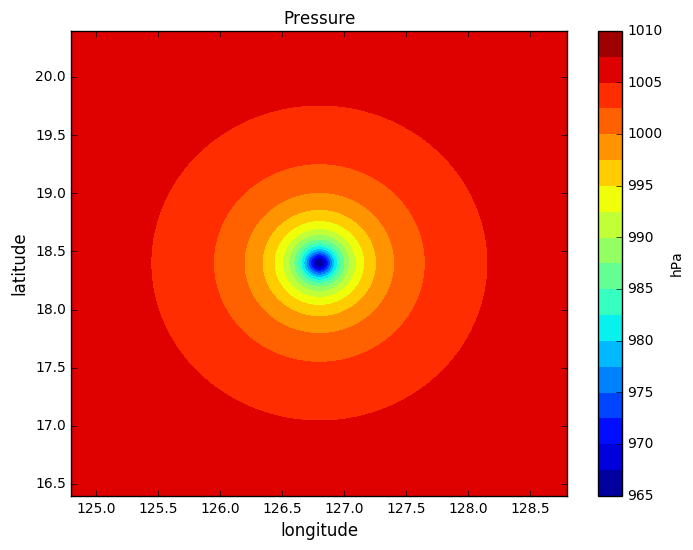

In [93]:
plt.figure(figsize=(8,6))
plt.contourf(xcell,ycell, prcell/100,20)
plt.xlabel('longitude',fontsize=12)
plt.ylabel('latitude',fontsize=12)
plt.title('Pressure',fontsize=12)
plt.colorbar(label='hPa')
plt.xlim((xhc-2,xhc+2))
plt.ylim((yhc-2,yhc+2))
plt.show()

In [94]:
# Calculate x
x3=calcx2(rcell,rmax,maxR,k)

In [95]:
# calculate v (without vt)
vr3=vel(rcell,b,rhoa,rmax,maxR,k,dp,x3)

In [45]:
# calculate v (with vt)
#v3vt=vel3(rcell, sinteta, costeta, vtx,vty, dp, pn, rmax, b, k, x3)

In [46]:
# calculate v (with vt)
v3x=-vr3*sinteta
v3y=vr3*costeta

v3xs=v3x+vtx*(1.-np.exp(-(rmax/rcell)**b))
v3ys=v3y+vty*(1.-np.exp(-(rmax/rcell)**b))

v3vt=np.sqrt(v3xs**2+v3ys**2)

In [47]:
# beta correction
beta=calcbeta(rcell,rmax)*deg2rad # (use np deg2rad)
cosb=np.cos(beta)
sinb=np.sin(beta)

vg=vr3

if yhc>0:
    vgx=-vg*(sinteta*cosb+costeta*sinb)
    vgy=vg*(costeta*cosb-sinteta*sinb)
else: 
    vgx=vg*(sinteta*cosb-costeta*sinb)
    vgy=-vg*(costeta*cosb+sinteta*sinb)


vgxvt=vgx+vtx*(1.-np.exp(-(rmax/rcell)**b)) # check
vgyvt=vgy+vty*(1.-np.exp(-(rmax/rcell)**b)) # check
vgvt=np.sqrt(vgxvt**2+vgyvt**2)

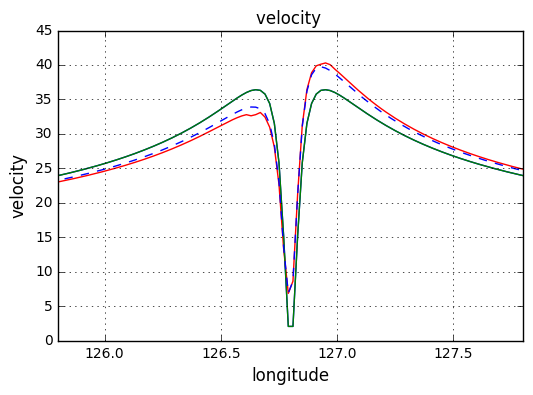

In [48]:
plt.figure(figsize=(6,4))
plt.plot(xcell[0,:],vg[500,:])
plt.plot(xcell[0,:],vgvt[500,:], '-r')
plt.plot(xcell[0,:],vr3[500,:], '-g')
plt.plot(xcell[0,:],v3vt[500,:], '--b')

plt.xlabel('longitude',fontsize=12)
plt.ylabel('velocity',fontsize=12)
plt.title('velocity ')
plt.xlim((xhc-1,xhc+1))
plt.grid(True)
plt.show()

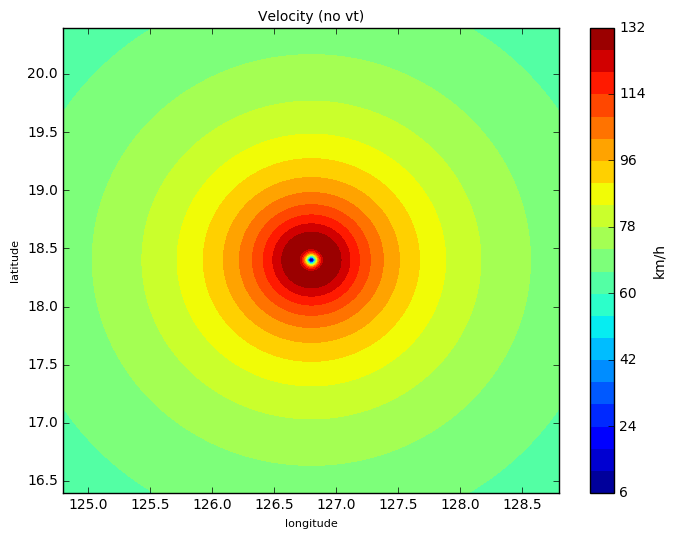

In [49]:
plt.figure(figsize=(8,6))
plt.contourf(xcell,ycell, vg*3.6,20)
plt.xlabel('longitude',fontsize=8)
plt.ylabel('latitude',fontsize=8)
plt.title('Velocity (no vt)',fontsize=10)
plt.colorbar(label='km/h')
plt.xlim((xhc-2,xhc+2))
plt.ylim((yhc-2,yhc+2))
plt.show()

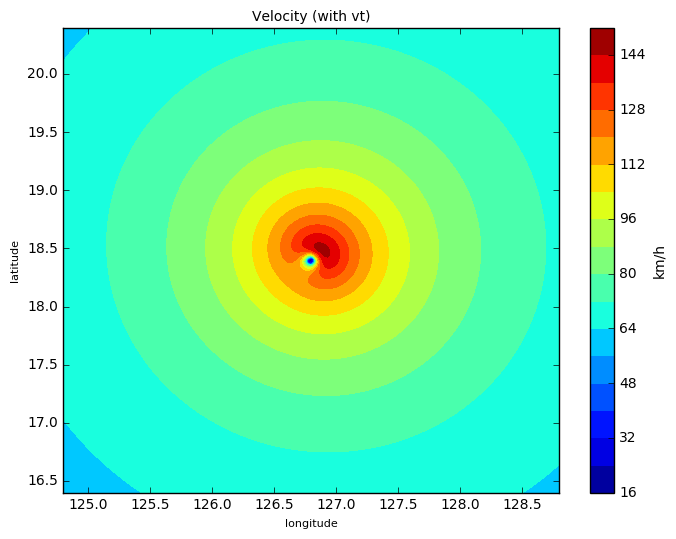

In [50]:
plt.figure(figsize=(8,6))
plt.contourf(xcell,ycell, v3vt*3.6,20)
plt.xlabel('longitude',fontsize=8)
plt.ylabel('latitude',fontsize=8)
plt.title('Velocity (with vt)',fontsize=10)
plt.colorbar(label='km/h')
plt.xlim((xhc-2,xhc+2))
plt.ylim((yhc-2,yhc+2))
plt.show()

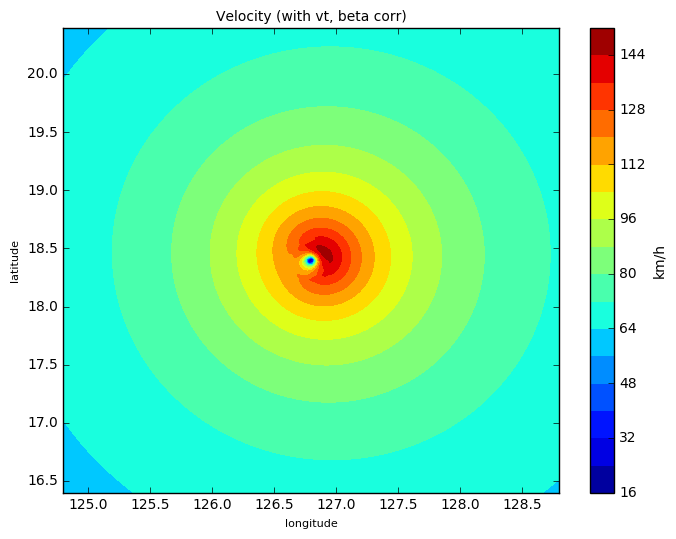

In [51]:
plt.figure(figsize=(8,6))
plt.contourf(xcell,ycell, vgvt*3.6,20)
plt.xlabel('longitude',fontsize=8)
plt.ylabel('latitude',fontsize=8)
plt.title('Velocity (with vt, beta corr)',fontsize=10)
plt.colorbar(label='km/h')
plt.xlim((xhc-2,xhc+2))
plt.ylim((yhc-2,yhc+2))
plt.show()